# ntbk 3 - Feature Engineering and Modeling

# Predicting Stock Market Performance Based on Speeches by The Fed

## Table of Contents

1. Import Packages, Modules, Data
2. Feature Engineering
3. Model Type Comparison
4. Model Selection and Tuning
5. Model Application
6. Modeling Scenario
7. Notebook Summary

## 1. Import Packages, Modules, Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#!pip3 install imblearn

In [59]:
import nltk
from imblearn.over_sampling import RandomOverSampler
from scipy.stats import uniform, randint
import warnings
import random

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#### Read and Inspect .pkl files from notebook 3_2_EDA

In [5]:
every_date_df = pd.read_pickle('data_intermediate/rolling_av_df.pkl')
master_df_speech_dates = pd.read_pickle('data_intermediate/speech_date_df.pkl')
sp_clean_df = pd.read_pickle('data_intermediate/sp500_cleaned.pkl')

In [6]:
every_date_df.head(2)

,txt_tokenized,vader_sent_overall,begin_sent,mid_sent,end_sent,Price,Open,High,Low,Change %,daily_span_y,Change%_7d_roll_past,daily_span_7d_roll_past,Price_roll_past,Change%_7d_roll_future,daily_span_7d_roll_future,Price_roll_future
Date,,,,,,,,,,,,,,,,,
2023-10-25,NaN,NaN,NaN,NaN,NaN,4201.149902,4230.040039,4230.040039,4196.250000,-1.10,33.790039,NaN,NaN,NaN,-0.571429,54.304269,4265.118652
2023-10-24,NaN,NaN,NaN,NaN,NaN,4247.680176,4235.790039,4259.379883,4219.430176,0.73,39.949707,NaN,NaN,NaN,-0.262857,55.328544,4289.758650


In [7]:
master_df_speech_dates.head(2)

,txt_tokenized,vader_sent_overall,begin_sent,mid_sent,end_sent,Price,Open,High,Low,Change %,daily_span_y,Change%_7d_roll_past,daily_span_7d_roll_past,Price_roll_past,Change%_7d_roll_future,daily_span_7d_roll_future,Price_roll_future,sp_chg_across_speech
Date,,,,,,,,,,,,,,,,,,
2023-10-19,"[for, release, on, delivery, noon, edt, octobe...",0.9983,0.9931,0.9595,0.9104,4278.000000,4321.359863,4339.540039,4269.689941,-0.85,69.850098,NaN,NaN,NaN,-0.261429,55.150042,4341.967146,NaN
2023-09-28,"[for, release, on, delivery, 400, pm, edt, sep...",0.9955,0.9290,0.9796,0.9895,4299.700195,4269.649902,4317.270020,4264.379883,0.59,52.890137,0.117143,58.577148,4276.575753,-0.467143,48.037040,4319.634277,43.058524


In [8]:
sp_clean_df.head(2)

,Price,Open,High,Low,Change %,daily_span
Date,,,,,,
2023-10-25,4201.149902,4230.040039,4230.040039,4196.250000,-1.10,33.790039
2023-10-24,4247.680176,4235.790039,4259.379883,4219.430176,0.73,39.949707


## 2. Feature Engineering

#### Create dataset for modeling
Extract relevant columns for input to models.

In [9]:
model_cols=['txt_tokenized', 'vader_sent_overall', 'begin_sent', 'mid_sent', 'end_sent', 
           'Price', 'Open', 'Change%_7d_roll_past', 'daily_span_7d_roll_past',
            'Price_roll_past', 'sp_chg_across_speech']
modeling_df = master_df_speech_dates[model_cols].copy().dropna()
mod_df_w_numeric_sp_chg = modeling_df.copy()  # to be used later, for numeric model eval


In [10]:
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2023-09-28 to 2020-04-09
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   txt_tokenized            25 non-null     object 
 1   vader_sent_overall       25 non-null     float64
 2   begin_sent               25 non-null     float64
 3   mid_sent                 25 non-null     float64
 4   end_sent                 25 non-null     float64
 5   Price                    25 non-null     float32
 6   Open                     25 non-null     float32
 7   Change%_7d_roll_past     25 non-null     float64
 8   daily_span_7d_roll_past  25 non-null     float64
 9   Price_roll_past          25 non-null     float64
 10  sp_chg_across_speech     25 non-null     float64
dtypes: float32(2), float64(8), object(1)
memory usage: 2.1+ KB


#### Create target variable

In [11]:
modeling_df['sp_increase_bool'] = (modeling_df['sp_chg_across_speech'] > 0).astype(int)
modeling_df = modeling_df.drop(columns='sp_chg_across_speech')

In [12]:
print('Shape:  ', modeling_df.shape, '\n')
modeling_df.info()

Shape:   (25, 11) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2023-09-28 to 2020-04-09
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   txt_tokenized            25 non-null     object 
 1   vader_sent_overall       25 non-null     float64
 2   begin_sent               25 non-null     float64
 3   mid_sent                 25 non-null     float64
 4   end_sent                 25 non-null     float64
 5   Price                    25 non-null     float32
 6   Open                     25 non-null     float32
 7   Change%_7d_roll_past     25 non-null     float64
 8   daily_span_7d_roll_past  25 non-null     float64
 9   Price_roll_past          25 non-null     float64
 10  sp_increase_bool         25 non-null     int64  
dtypes: float32(2), float64(7), int64(1), object(1)
memory usage: 2.1+ KB


In [13]:
modeling_df.head(2)

,txt_tokenized,vader_sent_overall,begin_sent,mid_sent,end_sent,Price,Open,Change%_7d_roll_past,daily_span_7d_roll_past,Price_roll_past,sp_increase_bool
Date,,,,,,,,,,,
2023-09-28,"[for, release, on, delivery, 400, pm, edt, sep...",0.9955,0.9290,0.9796,0.9895,4299.700195,4269.649902,0.117143,58.577148,4276.575753,1
2023-08-25,"[for, release, on, delivery, 1005, am, edt, 80...",0.9995,0.9966,0.9977,0.9508,4405.709961,4389.379883,0.390000,38.045689,4481.682896,0


#### Create TF-IDF df
- Apply StandardScaler() to numeric columns

In [14]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit transform 'txt_tokenized'
tfidf_matrix = tfidf_vectorizer.fit_transform(modeling_df['txt_tokenized'].apply(lambda x: ' '.join(x)))
# Create df from TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


#Apply Scaler to numeric df
scaler = StandardScaler()
df_mod_numeric = modeling_df.drop(columns='txt_tokenized')
scaled_data = scaler.fit_transform(df_mod_numeric)


# Convert scaled data back to df
scaled_df = pd.DataFrame(scaled_data, columns=df_mod_numeric.columns)

# Concatenate scaled numeric features with TF-IDF features horizontally
modeling_tfidf = pd.concat([scaled_df, tfidf_df], axis=1)
modeling_tfidf['sp_increase_bool'] = (modeling_tfidf['sp_increase_bool']> 0).astype(int)

#set aside validation_df for later, and remove 5 entries for model trianing
validation_tfidf = modeling_tfidf.copy()
modeling_tfidf = modeling_tfidf.iloc[0:20]

/Users/johnbaselj/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/johnbaselj/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/johnbaselj/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/johnbaselj/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future ver

In [15]:
print("modeling_tfidf \n   Shape:", modeling_tfidf.shape, '\n', '  Head:')

modeling_tfidf.head()

modeling_tfidf 
   Shape: (20, 5268) 
   Head:


,vader_sent_overall,begin_sent,mid_sent,end_sent,Price,Open,Change%_7d_roll_past,daily_span_7d_roll_past,Price_roll_past,sp_increase_bool,...,youngstown,youth,ystem,zabek,zealand,zeigler,zero,zhang,zones,zwick
0,0.297088,0.195730,0.552219,0.316239,0.592805,0.549757,0.005686,0.321929,0.543910,1,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.305969,0.355351,0.580101,0.239501,0.776291,0.760332,0.759883,-0.807444,0.911157,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.019004,0.0,0.0
2,-2.912038,0.334336,-1.520605,-3.472666,0.760246,0.734935,-0.018006,-1.349649,0.808207,0,...,0.0,0.0,0.029138,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,0.303749,0.328669,0.518637,0.280745,-0.065695,-0.120464,-0.239132,-0.100056,-0.030647,0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.305969,0.355824,0.530191,0.330516,0.212729,0.000203,-0.235183,0.787994,0.065557,0,...,0.0,0.0,0.000000,0.0,0.0,0.030554,0.0,0.000000,0.0,0.0


#### Create Bag of Words df
- Apply StandardScaler() to numeric columns

In [16]:
count_vectorizer = CountVectorizer(stop_words='english')

# Fit transform 'txt_tokenized' 
count_matrix = count_vectorizer.fit_transform(modeling_df['txt_tokenized'].apply(lambda x: ' '.join(x)))
# create df from BoW matrix
count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())


# Convert scaled data back to df
scaled_df = pd.DataFrame(scaled_data, columns=df_mod_numeric.columns)

# Concatenate scaled numeric features with TF-IDF features horizontally
modeling_bow = pd.concat([scaled_df, count_df], axis=1)
modeling_bow['sp_increase_bool'] = (modeling_bow['sp_increase_bool']> 0).astype(int)

#set aside validation_df for later, and remove 5 entries for model trianing
validation_df = modeling_bow.copy()

validation_set = modeling_bow.sample(frac=0.20, random_state=42)
modeling_bow = modeling_bow.drop(validation_set.index)


In [17]:
print("modeling_bow \n   Shape:", modeling_bow.shape, '\n', '  Head:')

modeling_bow.head(3)

modeling_bow 
   Shape: (20, 5268) 
   Head:


,vader_sent_overall,begin_sent,mid_sent,end_sent,Price,Open,Change%_7d_roll_past,daily_span_7d_roll_past,Price_roll_past,sp_increase_bool,...,youngstown,youth,ystem,zabek,zealand,zeigler,zero,zhang,zones,zwick
1,0.305969,0.355351,0.580101,0.239501,0.776291,0.760332,0.759883,-0.807444,0.911157,0,...,0,0,0,0,0,0,0,1,0,0
2,-2.912038,0.334336,-1.520605,-3.472666,0.760246,0.734935,-0.018006,-1.349649,0.808207,0,...,0,0,1,0,0,0,0,0,0,0
3,0.303749,0.328669,0.518637,0.280745,-0.065695,-0.120464,-0.239132,-0.100056,-0.030647,0,...,0,0,0,0,0,0,0,0,0,0


#### Oversample to create balanced classes
Visualization of initial class balance:

Text(0.5, 1.0, 'Frequency of sp_increase_bool Values')

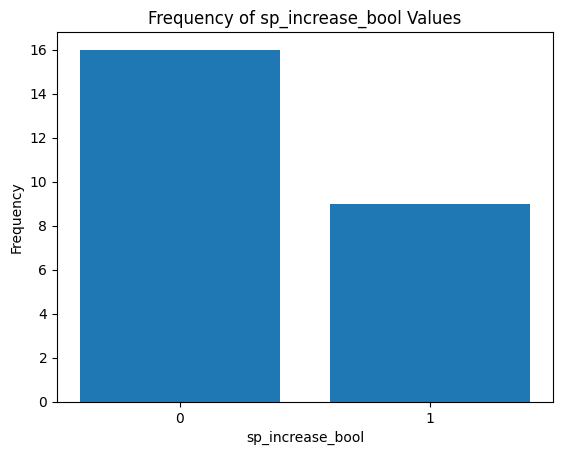

In [18]:
value_counts = modeling_df['sp_increase_bool'].value_counts()

plt.bar(value_counts.index, value_counts.values)

plt.xlabel('sp_increase_bool')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['0', '1'])  # Customizing x-axis labels
plt.title('Frequency of sp_increase_bool Values')

#### Create tfidf_balanced df via oversampling minority class

In [19]:
warnings.filterwarnings("ignore")
X = modeling_tfidf.drop(columns=['sp_increase_bool'])  # Features
y = modeling_tfidf['sp_increase_bool']  # Target variable

# Initialize
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine into new df
tfidf_balanced = pd.concat([X_resampled, y_resampled], axis=1)

print(tfidf_balanced['sp_increase_bool'].value_counts())

sp_increase_bool
1    12
0    12
Name: count, dtype: int64


#### Create bow_balanced df via oversampling minority class of modeling_bow

In [20]:
X = modeling_bow.drop(columns=['sp_increase_bool'])  # Features
y = modeling_bow['sp_increase_bool']  # Target variable

# Initialize
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine into new df
bow_balanced = pd.concat([X_resampled, y_resampled], axis=1)

print(bow_balanced['sp_increase_bool'].value_counts())

sp_increase_bool
0    13
1    13
Name: count, dtype: int64


#### Make X, y splits for each df

In [21]:
# modeling_tfidf (original class ratios)
X_tfidf = modeling_tfidf.drop(columns=['sp_increase_bool'])
y_tfidf = modeling_tfidf['sp_increase_bool']

In [22]:
# modeling_bow (original class ratios)
X_bow = modeling_bow.drop(columns=['sp_increase_bool'])
y_bow = modeling_bow['sp_increase_bool']

In [23]:
# tfidf_balanced
X_tf_bal = tfidf_balanced.drop(columns=['sp_increase_bool'])
y_tf_bal = tfidf_balanced['sp_increase_bool']

In [24]:
# bow_balanced
X_bow_bal = bow_balanced.drop(columns=['sp_increase_bool'])
y_bow_bal = bow_balanced['sp_increase_bool']

## 3. Model Type Comparison

#### Define function that trains and evaluates LogReg, RF, and SVM for input X,y splits

In [25]:
def eval_model_types(X, y):
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize models
    logistic_regression = LogisticRegression()
    random_forest = RandomForestClassifier()
    svm = SVC()

    models = [logistic_regression, random_forest, svm]
    model_names = ["Logistic Regression", "Random Forest", "SVM"]

    for model, model_name in zip(models, model_names):
        print(f"Model: {model_name}")

        if model_name == "Logistic Regression":
            # hyperparam tuning
            param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_

        elif model_name == "Random Forest":
            # hyperparam tuning
            param_grid = {
                'n_estimators': [100, 200, 300],
                'max_depth': [10, 20, 30],
                'min_samples_split': [2, 5, 10]
            }
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_

        # Perform 5-fold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

        print(f"Cross-Validation Scores: {cv_scores}")
        print(f"Mean CV Accuracy: {cv_scores.mean()}")

        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Test Accuracy: {accuracy}")
        print(f"Test F1-Score: {f1}")
        print("\n")

#### Apply eval_model_types() to each split tfidf natural, bow natural, tfidf balanced, bow balanced

In [26]:
'''
print('Model evaluation using TF-IDF vector, natural (unbalanced) classes\n')
eval_model_types(X_tfidf,y_tfidf)
''';

"\nprint('Model evaluation using TF-IDF vector, natural (unbalanced) classes\n')\neval_model_types(X_tfidf,y_tfidf)\n"

In [27]:
'''
print('Model evaluation using Bag Of Words vector, natural (unbalanced) classes\n')
eval_model_types(X_bow,y_bow)
'''

"\nprint('Model evaluation using Bag Of Words vector, natural (unbalanced) classes\n')\neval_model_types(X_bow,y_bow)\n"

In [28]:
'''
print('Model evaluation using TF-IDF vector, balanced classes\n')
eval_model_types(X_tf_bal, y_tf_bal)
'''

"\nprint('Model evaluation using TF-IDF vector, balanced classes\n')\neval_model_types(X_tf_bal, y_tf_bal)\n"

In [29]:
'''
print('Model evaluation using Bag Of Words vector, balanced classes\n')
eval_model_types(X_bow_bal,y_bow_bal)
'''

"\nprint('Model evaluation using Bag Of Words vector, balanced classes\n')\neval_model_types(X_bow_bal,y_bow_bal)\n"

## 4. Model Tuning and Selection

In the above comparison of model types:
- It appears that the best input data form for training a model is using Bag of Words text vectorizer, and using balanced classes for training
- Logistic regression and Random Forest models performed the best, and they are close to equal in performance metrics.
- To compare LogReg and RF, we will further tune each using balanced data, and see which predicts the original unbalanced dataset best


### 4.1 Tune Linear Regression Model
Revisiting Linear Regression model's hyperparameter tuning, using RandomizedSearchCV

In [30]:
# This code block commented out to reduce future ntbk runtime
# Optimal Hyperparams calculated here are applied to LogReg models that follow

'''
# Define the hyperparameter grid
param_dist = {
    'C': uniform(loc=0, scale=4),  # Vary the regularization strength
    'penalty': ['l1', 'l2']  # Regularization type (L1 or L2)
}

# Initialize LogReg
logistic_regression = LogisticRegression()

# create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    logistic_regression, param_distributions=param_dist,
    n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)

# Perform random search on the training data
random_search.fit(X_bow_bal, y_bow_bal)

# Get the best estimator and hyperparameters
best_logistic_regression = random_search.best_estimator_
best_hyperparameters = random_search.best_params_
print("Best Hyperparameters:", best_hyperparameters)

# Make predictions with the optimized model
y_pred_optimized = best_logistic_regression.predict(X_bow_bal)

# eval
accuracy_optimized = accuracy_score(y_bow_bal, y_pred_optimized)
print(f"Optimized Model Accuracy: {accuracy_optimized}")

''';

Output of above Hyperparam tuning:
- Best Hyperparameters: {'C': 0.734, 'penalty': 'l2'}

#### Instantiate LogReg model with optimized Hyperparams

In [31]:
#best_logreg = LogisticRegression(C=0.734, penalty='l2')
best_logreg = LogisticRegression(C=0.734, penalty='l2')

Train on Balanced Classes, all data excluding validation set

In [32]:
best_logreg.fit(X_bow_bal, y_bow_bal)

LogisticRegression(C=0.734)

#### Prepare validation data for model assessment

In [33]:
X_val = validation_df.drop(columns=['sp_increase_bool'])
y_val = validation_df['sp_increase_bool']

Evaluate on Natural/Imbalanced classes

In [34]:
y_pred = best_logreg.predict(X_val)

# Evaluate the optimized model
accuracy_optimized = accuracy_score(y_val, y_pred)
print(f"Optimized Model Accuracy: {accuracy_optimized}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

Optimized Model Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.80      0.89      0.84         9

    accuracy                           0.88        25
   macro avg       0.87      0.88      0.87        25
weighted avg       0.89      0.88      0.88        25

[[14  2]
 [ 1  8]]


##### Logistic Regression Model Accuracy: 0.88

### 4.2 Tune Random Forest Regressor Model
Revisiting RF model's hyperparameter tuning, using RandomizedSearchCV

In [35]:
# This code block commented out to reduce future ntbk runtime
# Optimal Hyperparams calculated here are applied to RF models that follow

'''
# hyperparam grid 
param_dist = {
    'n_estimators': randint(10, 200),  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2', None],  
    'max_depth': randint(5, 50, 10), 
    'min_samples_split': randint(2, 20), 
    'min_samples_leaf': randint(1, 20),  
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize Random Forest
random_forest = RandomForestClassifier()

# Create RandomizedSearchCV object for Random Forest
random_search_rf = RandomizedSearchCV(
    random_forest, param_distributions=param_dist,
    n_iter=100, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)

# Perform random search on the training data
random_search_rf.fit(X_bow_bal, y_bow_bal)

# Get the best estimator and hyperparameters for Random Forest
best_random_forest = random_search_rf.best_estimator_
best_hyperparameters_rf = random_search_rf.best_params_
print("Best Hyperparameters for Random Forest:", best_hyperparameters_rf)

# Make predictions with the optimized Random Forest model
y_pred_optimized_rf = best_random_forest.predict(X_bow_bal)

# Evaluate the Random Forest model
accuracy_optimized_rf = accuracy_score(y_bow_bal, y_pred_optimized_rf)
print(f"Optimized Random Forest Model Accuracy: {accuracy_optimized_rf}")

''';

Output from above:
- Best Hyperparameters for Random Forest: {'bootstrap': False, 'max_depth': 54, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 63}

#### Instantiate model with optimized Hyperparams

In [36]:
best_hyp_params = {'bootstrap': False, 'max_depth': 54, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 63}
best_rf = RandomForestClassifier(**best_hyp_params)

Train on Balanced Classes, all data excluding validation set

In [37]:
best_rf.fit(X_bow_bal, y_bow_bal)

RandomForestClassifier(bootstrap=False, max_depth=54, max_features=None,
                       min_samples_leaf=2, min_samples_split=7,
                       n_estimators=63)

Evaluate on Natural/Imbalanced Classes

In [38]:
y_pred = best_rf.predict(X_val)      #test on the unbalanced BagOfWords X

# Evaluate the optimized model
accuracy_optimized = accuracy_score(y_val, y_pred)
print(f"Optimized Model Accuracy: {accuracy_optimized}")
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

Optimized Model Accuracy: 0.92
              precision    recall  f1-score   support

           0       1.00      0.88      0.93        16
           1       0.82      1.00      0.90         9

    accuracy                           0.92        25
   macro avg       0.91      0.94      0.92        25
weighted avg       0.93      0.92      0.92        25

[[14  2]
 [ 0  9]]


# ************************************

## Random Forest Model Accuracy: 0.92
## Logistic Regression Model Accuracy: 0.88

# ************************************

Model Evaluation will continue using the Logistic Regression Model:

## 5. Model Evaluation

In [39]:
# use bag of words representations for eval
X_test = X_val
y_test = y_val

Model Eval Metrics

In [40]:
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.92
Precision: 0.82
Recall: 1.00
F1-Score: 0.90
ROC AUC: 0.98


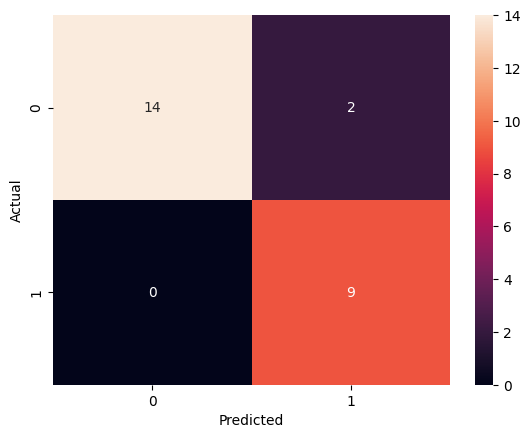

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

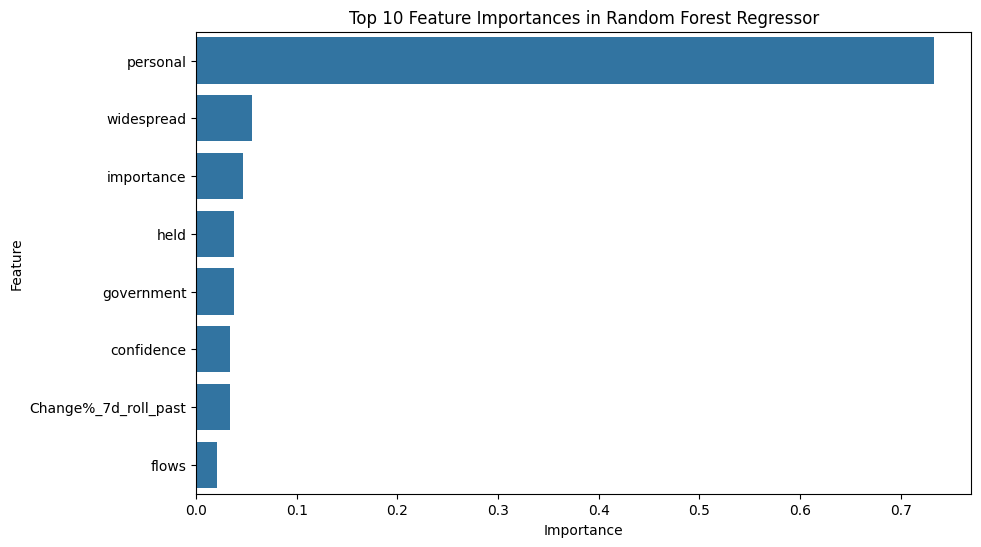

In [55]:
feature_importances = best_rf.feature_importances_

# Match feature importances to feature names
feature_names = X_test.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_10_importance_df = importance_df.sort_values(by='Importance', ascending=False).head(8)

# Create a bar plot for the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_importance_df)
plt.title('Top 10 Feature Importances in Random Forest Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

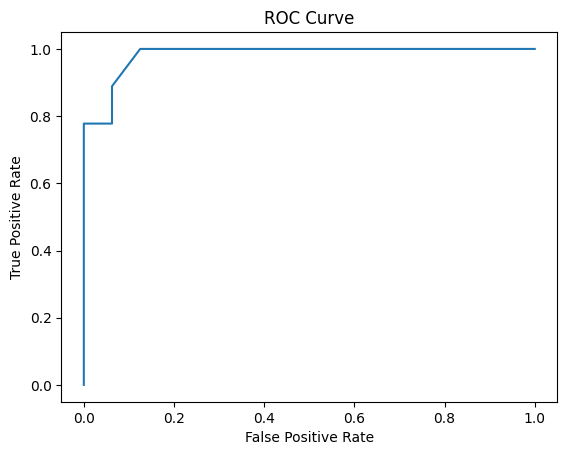

In [43]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

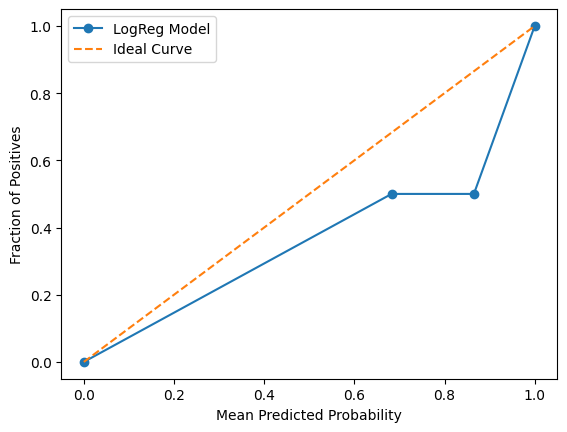

In [44]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, best_rf.predict_proba(X_test)[:, 1], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='LogReg Model')
ideal_curve = [0, 1]
plt.plot(ideal_curve, ideal_curve, linestyle='--', label='Ideal Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()

#### Evaluation metrics on a CV basis 

Because of the relatively small data set, Cross Validation modeling scores may be a more appropriate measure of model predictive power than the above eval using small validation set.

In [76]:
kf = KFold(n_splits=4, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf, X_test, y_test, cv=kf, scoring='accuracy')

print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()}")

CV Accuracy Scores: [0.71428571 0.66666667 0.66666667 0.83333333]
Mean CV Accuracy: 0.7202380952380952


In [78]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score

predicted = cross_val_predict(best_rf, X_test, y_test, cv=kf)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)
f1 = f1_score(y_test, predicted)

print('CV Precision: ', precision)
print('CV Recall: ', recall)
print('CV F1 score: ', f1)

CV Precision:  0.5833333333333334
CV Recall:  0.7777777777777778
CV F1 score:  0.6666666666666666


In [82]:
predicted_probs = cross_val_predict(best_rf, X_test, y_test, cv=kf, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_test, predicted_probs[:, 1])
roc_auc = roc_auc_score(y_test, predicted_probs[:, 1])

print('ROC AUC: ', roc_auc)

ROC AUC:  0.6805555555555556


## 6. Modeling Scenario

To demonstrate the potential monetary impact of predicting the stock market with this model, we will create a set of instructions for an investor to follow in applying the model, and calculate about how much monetary benefit it could have brought if applied to the past speeches
1. At the conclusion of a speech, use that speech's text and updated historical data as inputs to the trained model to predict whether the stock market will go up in the next week.
2. If the market is predicted to go up:
- make an investment by buying stock in an SP500 index fund
- sell that stock one week later
3. If the market is predicted to go down:
- make an investment by buying stock in an SP500 INVERSE leveraged index fund
- sell that stock one week later

In [47]:
# define variable that represents the week over week stock market change as a percentage of market value
mod_df_w_numeric_sp_chg['wk_pct_chg'] = mod_df_w_numeric_sp_chg['sp_chg_across_speech']/mod_df_w_numeric_sp_chg['Price_roll_past']
wk_pct_chg = mod_df_w_numeric_sp_chg['wk_pct_chg']

mod_df_w_numeric_sp_chg.head(2)

,txt_tokenized,vader_sent_overall,begin_sent,mid_sent,end_sent,Price,Open,Change%_7d_roll_past,daily_span_7d_roll_past,Price_roll_past,sp_chg_across_speech,wk_pct_chg
Date,,,,,,,,,,,,
2023-09-28,"[for, release, on, delivery, 400, pm, edt, sep...",0.9955,0.9290,0.9796,0.9895,4299.700195,4269.649902,0.117143,58.577148,4276.575753,43.058524,0.010068
2023-08-25,"[for, release, on, delivery, 1005, am, edt, 80...",0.9995,0.9966,0.9977,0.9508,4405.709961,4389.379883,0.390000,38.045689,4481.682896,-89.480120,-0.019966


Simulate what would happen as a result of following the above instructions, repeated over time and reinvesting the previous value for each new speech. 

Note: this simulation has a starting value of $100 invested, but will behave proportionatley for any investment

In [48]:
y_pred

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0])

In [49]:
wk_pct_chg[0:5]

Date
2023-09-28    0.010068
2023-08-25   -0.019966
2023-06-29   -0.012685
2023-01-10   -0.023787
2022-11-30   -0.002043
Name: wk_pct_chg, dtype: float64

In [61]:
cash = 100
value = [100]
idx=0
for prediction in y_pred:
    if prediction == 1:
        cash = cash * (1 + wk_pct_chg[idx])
        value.append(cash)
        idx+=1
        
    else:
        cash = cash * (1 - wk_pct_chg[idx])
        value.append(cash)
        idx+=1

In [70]:
random_ints = random.choices([-1, 1], weights=[0.28, 0.72], k=25)
cash = 100
value = [100]
idx = 0

for guess in random_ints:
    if wk_pct_chg[idx] > 0:
        cash = cash * (1 + guess*wk_pct_chg[idx])
        value.append(cash)
        idx+=1
    else:
        cash = cash * (1 - guess*wk_pct_chg[idx])
        value.append(cash)
        idx+=1

In [71]:
print(random_ints)
print(wk_pct_chg)

[1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1]
Date
2023-09-28    0.010068
2023-08-25   -0.019966
2023-06-29   -0.012685
2023-01-10   -0.023787
2022-11-30   -0.002043
2022-09-28    0.006790
2022-08-26    0.048431
2022-06-17   -0.003502
2022-05-24   -0.028325
2022-03-21   -0.043079
2021-11-29    0.018685
2021-11-09   -0.002048
2021-11-08   -0.004883
2021-09-24    0.011219
2021-08-27   -0.012268
2021-08-17    0.000501
2021-05-03    0.000796
2021-03-18    0.005458
2021-02-10   -0.010710
2020-10-06   -0.028478
2020-08-27   -0.019879
2020-06-19    0.000837
2020-05-21   -0.034587
2020-05-13   -0.009093
2020-04-09   -0.067547
Name: wk_pct_chg, dtype: float64


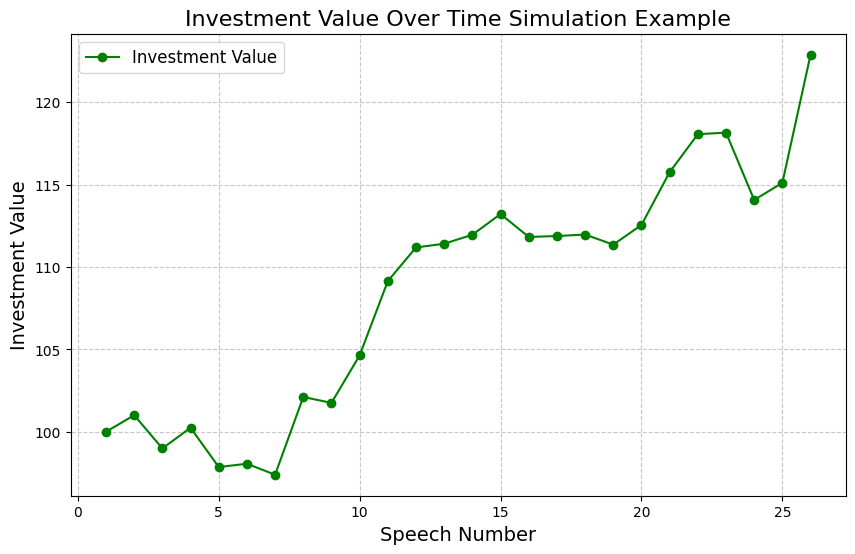

In [87]:
x = range(1, len(value) + 1)

plt.figure(figsize=(10, 6))
plt.plot(x, value, label='Investment Value', color='g', markersize=6, marker='o', linestyle='-')

# labels
plt.xlabel('Speech Number', fontsize=14)
plt.ylabel('Investment Value', fontsize=14)
plt.title('Investment Value Over Time Simulation Example', fontsize=16)

# Customize
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=12)
plt.show()  

##### Run the above simulation multiple times to visualize distribution

In [90]:
results = []
for i in range(1000):
    random.seed(i)
    random_ints = random.choices([-1, 1], weights=[0.28, 0.72], k=25)
    cash = 100
    idx = 0
    for guess in random_ints:
        if wk_pct_chg[idx] > 0:
            cash = cash * (1 + guess*wk_pct_chg[idx])
            idx+=1
        else:
            cash = cash * (1 - guess*wk_pct_chg[idx])
            idx+=1
            
    results.append(cash)

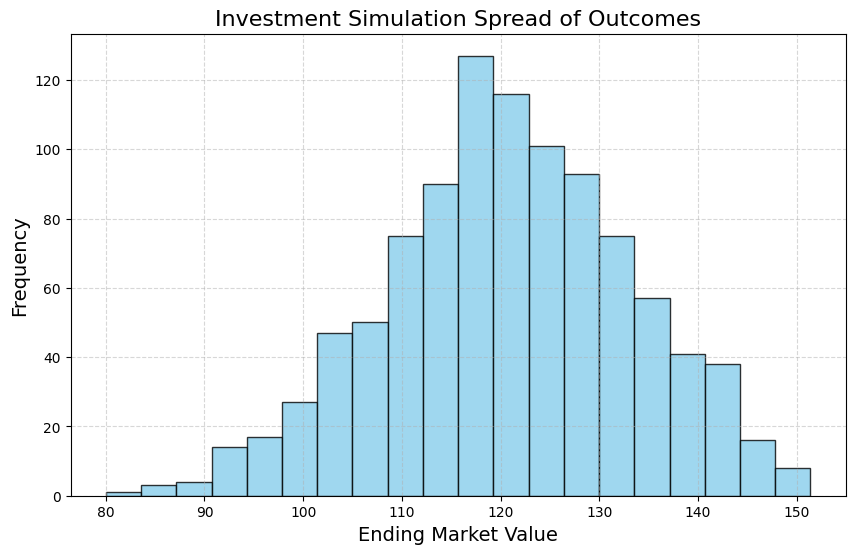

In [96]:
plt.figure(figsize=(10, 6))
plt.hist(results, bins=20, color='skyblue', edgecolor='k', alpha=0.8)


plt.xlabel('Ending Market Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Investment Simulation Spread of Outcomes', fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)

## 7. Notebook Summary

#### Feature engineering
- features relevent for modeling were selected. For example, rolling stock data representing the past for each speech was kept, but data from the "future" was removed, because this data will not be available to use when applying the model in the future.
- target variable was created: a boolean value representing whether or not the SP500 increased in value from the week before, to the week after a given speech.
- Speech texts were vectorized using two models for comparison: TF-IDF and Bag of Words
- After vecorization, a subset of data was removed to serve as a validation set
- Entries were oversampled to make balanced classes for model training. Both natural datasets and oversampled datasets were preserved for comparison
- Data split into independent variables X and response variable y formodel trianing

#### Initial Model Type Comparison
- Logistic Regression, Random Forest Classifier, and Support Vector Machine models were trained and evaluated using each of 4 data inputs to establish which models and data approach work best with the available data.
    - TF-IDF vectorization with balanced classes
    - TF-IDF with natural/unbalanced classes
    - BoW vectorization with balanced classes
    - Bow with natural/unbalanced classes
- LogReg and RFC models were selected and further tuned


#### Final Modeling
- Random Forest Classifier was evaluated to have the strongest predictive power
- RFC trained on all training data, then evaluated using the full natural dataset, including the holdout validation data